<div align='center'><font size="5" color='#353B47'>Handwritten Letters Classification</font></div>
<div align='center'><font size="4" color="#353B47">With Convolutional Neural Networks</font></div>
<br>
<hr>

Source 1: https://www.kaggle.com/friskycodeur/image-recognition-using-cnn-explained/notebook <br>
Source 2: https://www.kaggle.com/bryanb/cnn-for-handwritten-letters-classification#5.-Going-further,-A-model-for-background-recognition

# <div id="chap1">1. Setup</div>

## <font color='blue'>1.1 Dependancies</font>

In [74]:
# Remove warning messages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

# navigation and read files
import glob
import os

# Read HDF5 binary data format: convenient for large data storage
import h5py

# Read and display images
import matplotlib.pyplot as plt
import imageio
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow import keras

# DL dependancies
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.metrics import classification_report ,confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU,GlobalMaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## <font color='blue'>1.2 Import Data</font>

In [42]:

print(f'The size of training data is {train.shape[0]} and that of test data is {test.shape[0]}')

The size of training data is 1650 and that of test data is 5940


In [43]:
y_train

0        1
1        1
2        1
3        1
4        1
        ..
1645    33
1646    33
1647    33
1648    33
1649    33
Name: label, Length: 1650, dtype: int64

## <font color='blue'>1.4 Shuffle data</font>

In [7]:
# Shuffle data
#data = shuffle(data, random_state = 42)

# <div id="chap2">2. Preprocessing</div>

## <font color='blue'>2.1 One hot encoding</font>

In [8]:
#data.head()

,letter,label,file,background,source
6491,щ,27,27_212.png,2,letters2/
2012,в,3,03_53.png,2,letters2/
13295,ы,29,29_336.png,3,letters3/
11270,с,19,19_311.png,3,letters3/
12837,щ,27,27_278.png,3,letters3/


<div align="justify"><font size="3">For each row, we get the letter, its index in letters vector, the handwritten letter as .png file, the background of the paper the letter was written and the source. The goal of the preprocessing step is to encode the background and the letter column.</font></div>

In [44]:
x_train=train.drop('label',axis=1).values
x_train

array([['а', '01_01.png', 0],
       ['а', '01_02.png', 0],
       ['а', '01_03.png', 0],
       ...,
       ['я', '33_48.png', 1],
       ['я', '33_49.png', 1],
       ['я', '33_50.png', 1]], dtype=object)

In [9]:
# Get all labels in one string
letters = '' 
for letter in data.letter.unique():
    letters += letter
    
# Which letter is written on each image
labels = data.label

Meaning of background categories

* striped = 0
* gridded = 1
* no background = 2
* graph paper = 3

In [10]:
def ohe_letters(label):
    '''
    One hot encoding for the target label
    '''
    resu = np.zeros(len(letters))
    index = letters.index(label)
    resu[index] = 1
    return resu

def ohe_backgrounds(label):
    '''
    One hot encoding for background column
    '''
    resu = np.zeros(len(data.background.unique()))
    resu[label] = 1
    return resu

In [11]:
data['encoded_letter'] = data['letter'].apply(lambda x:ohe_letters(x))
data['encoded_background'] = data['background'].apply(lambda x:ohe_backgrounds(x))

In [12]:
data.head()

,letter,label,file,background,source,encoded_letter,encoded_background
6491,щ,27,27_212.png,2,letters2/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
2012,в,3,03_53.png,2,letters2/,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
13295,ы,29,29_336.png,3,letters3/,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
11270,с,19,19_311.png,3,letters3/,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
12837,щ,27,27_278.png,3,letters3/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"


<div align="justify"><font size="3">The data has the correct format, we can now extract the information we need to train a model.</font></div>

## <font color='blue'>2.2 Reshape, Filter and Normalize</font>

In [13]:
# Store all png images into one numpy array
images = []
# Will be the target
encoded_labels = []

backgrounds = []
encoded_backgrounds = []

# I want to be sure that every image is consitent
for i, row in data.iterrows():
    img_name = row['file']
    numpy_image = cv2.imread(os.path.join(PATH_TO_DATA + row['source'], img_name))
    if numpy_image.shape == (32, 32, 3):
        images.append(numpy_image)
        encoded_labels.append(row['encoded_letter'])
        backgrounds.append(row['background'])
        encoded_backgrounds.append(row['encoded_background'])
        
# Normalize array of images
images = np.array(images)/255

## <font color='blue'>2.3 Display letters</font>

In [14]:
def display_image(images_list, list_of_labels = np.arange(9)):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    for index in list_of_labels:
        
        # Get corresponding label
        ohe_label = encoded_labels[index]
        index_letter = list(ohe_label).index(1)
        associated_letter = letters[index_letter]

        # Get background
        associated_background = backgrounds[index]
        
        
        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Label: %s \n'%associated_letter+\
                 'Background: %s\n'%associated_background,
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(images[index])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    # show the figure
    plt.show()

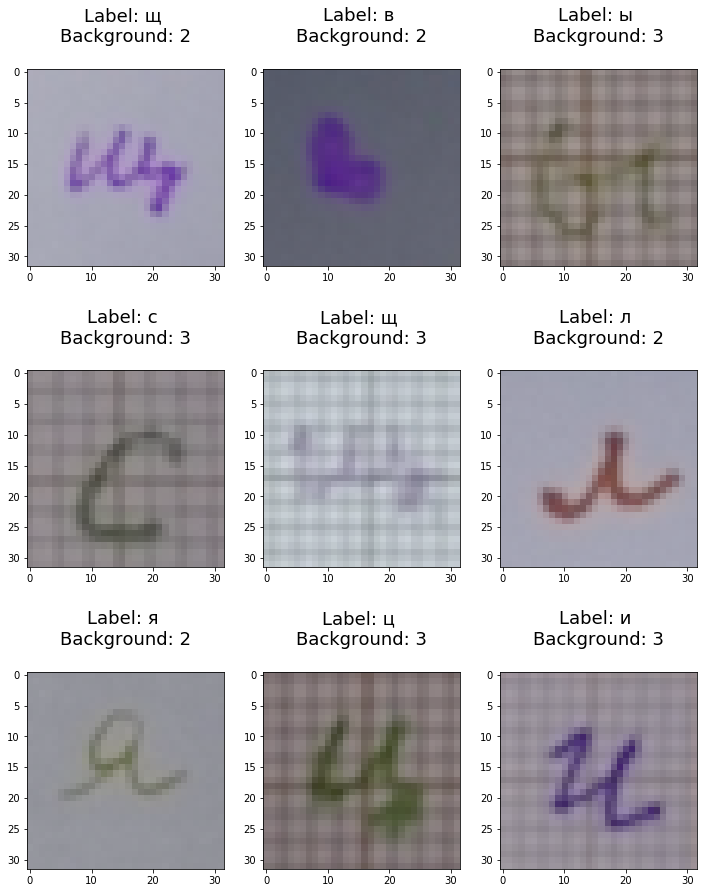

In [15]:
display_image(images)

## <font color='blue'>2.4 Prepare Train and Validation set</font>

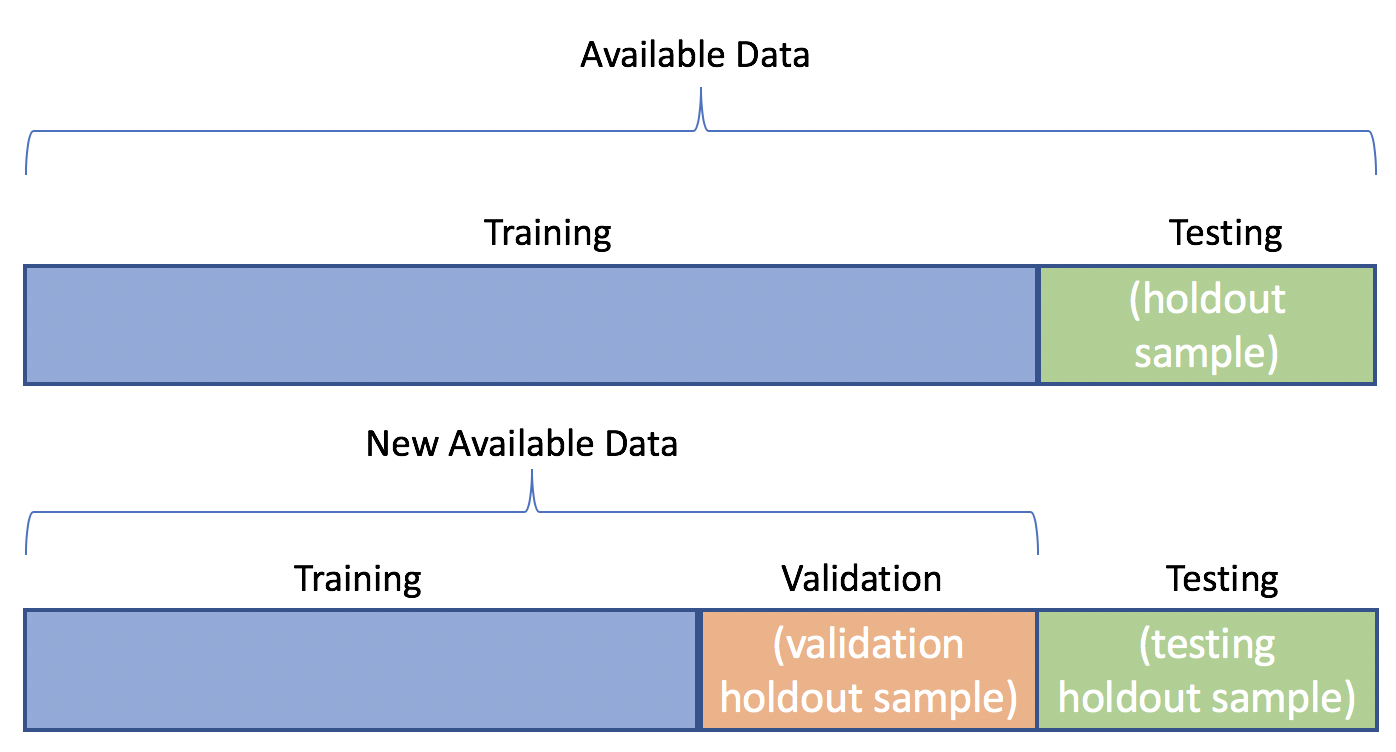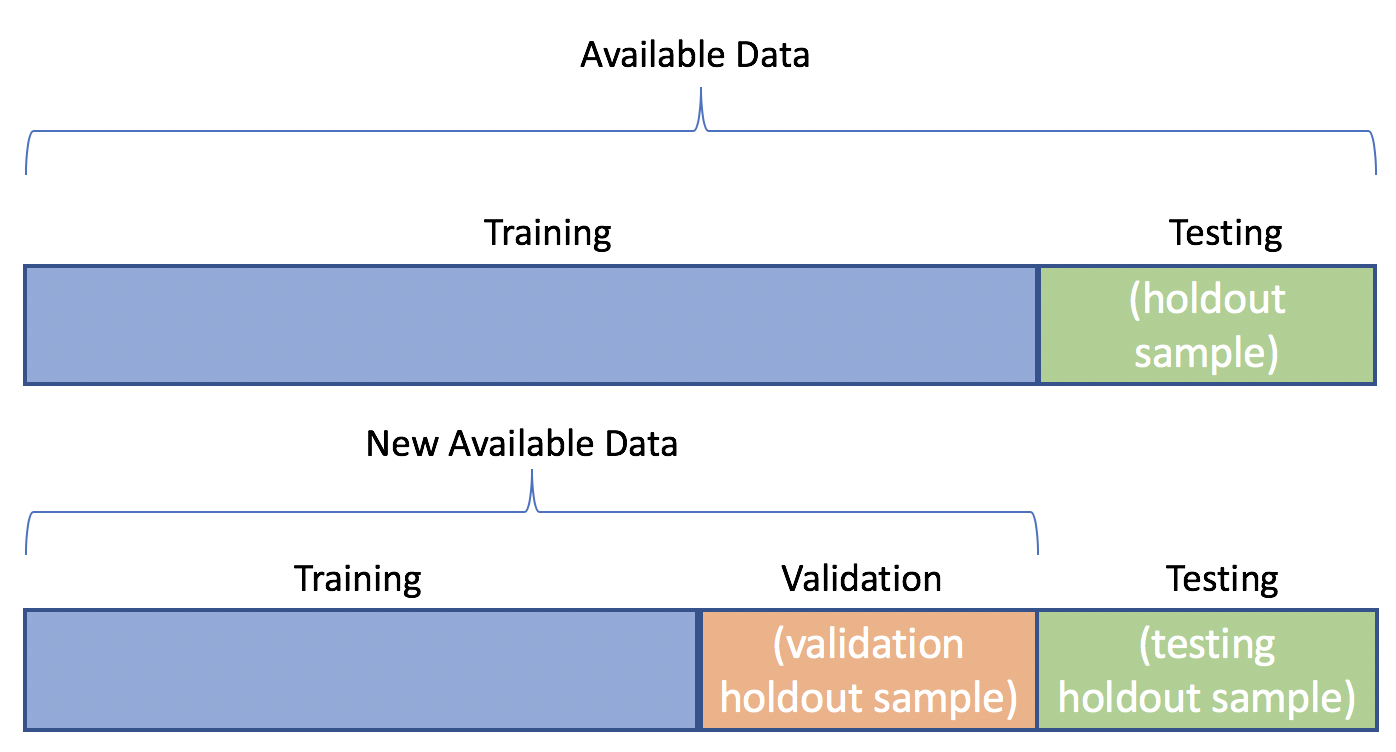

In [16]:
# Define X_data and target
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=.2, 
                                                  stratify = y, 
                                                  random_state=42)

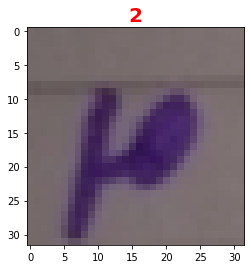

In [49]:
random_image=X_train[78]
random_label=y_train[78]
plt.imshow(random_image,cmap='binary')
plt.title(random_label,fontsize=20,weight='bold',color='red')
plt.show()

In [50]:
random_image.max()

0.5058823529411764

In [51]:
random_image.min()

0.06666666666666667

<div align="justify"><font size="3">We're all set and the data are ready to feed the model. Let's create the model now.</font></div>

In [ ]:
x_train_scaled=x_train/255
x_val_scaled=x_val/255

In [ ]:
plt.imshow(x_train_scaled[78],cmap='binary')
plt.title(y_train[78],fontsize=20,weight='bold',color='red')
plt.show()

<img style="float: left;" src="lily.png"> 

# <div id="chap3">3. A CNN Model for Handwritten Letters Classification</div>

## <font color='blue'>3.1 What is a CNN ?</font>

<div align="justify"><font size="3">A CNN is quite similar to Classic Neural Networks (RegularNets) where there are neurons with weights and biases. Just like in RegularNets, we use a loss function and an optimizer in CNNs. Additionally though, in CNNs, there are Convolutional Layers, Pooling Layers, and Flatten Layers. CNNs are mainly used for image classification.

### <font color="orange">CNN layers

* **Convolutional layer** 

> <div align="justify"><font size="3">The very first layer where we extract features from the images in our datasets. Due to the fact that pixels are only related with the adjacent and close pixels, convolution allows us to preserve the relationship between different parts of an image. Convolution is basically filtering the image with a smaller pixel filter to decrease the size of the image without loosing the relationship between pixels. When we apply convolution to 5x5 image by using a 3x3 filter with 1x1 stride (1 pixel shift at each step). We will end up having a 3x3 output (64% decrease in complexity).</font></div>

* **Pooling layer**

> <div align="justify"><font size="3">When constructing CNNs, it is common to insert pooling layers after each convolution layer to reduce the spatial size of the representation to reduce the parameter counts which reduces the computational complexity. In addition, pooling layers also <b>helps with the overfitting problem</b>. Basically we select a pooling size to reduce the amount of the parameters by selecting the maximum, average, or sum values inside these pixels.</font></div>

* **Flatten layer**

> <div align="justify"><font size="3">Flattens the input. Does not affect the batch size.</font></div>

## <font color='blue'>3.2 Parameters</font>

In [17]:
# Define image dimensions
IMG_ROWS = 32
IMG_COLS = 32
# 3 stands for RGB images, 1 if greyscaled images
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)

# Number of classes to consider
NUM_CLASSES = len(letters)
# Group of training samples
BATCH_SIZE = 64
# Number of complete presentations of the dataset to be learned
EPOCHS = 100

## <font color='blue'>3.3 Good reflexes to have</font>

* **Add dropout**

> <div align="justify"><font size="3">Dropout refers to ignoring neurons during the training phase of certain set of neurons which is chosen at random.

* **LeakyRelu**

> <div align="justify"><font size="3">The advantage of using Leaky ReLU instead of ReLU is that in this way we cannot have vanishing gradient. Parametric ReLU has the same advantage with the only difference that the slope of the output for negative inputs is a learnable parameter while in the Leaky ReLU it's a hyperparameter.

* **Add callbacks**

> <div align="justify"><font size="3">A callback is a function that is to be executed after another function has finished executing hence the name 'call back'. With callbacks, you can define earlystopping criterias for your model if it doesn't learn anymore through epochs. Callback allows you to store some information at the end of each epoch so you can check your model's performance.

## <font color='blue'>3.4 Define a custom metric</font>

In [18]:
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

## <font color='blue'>3.5 Create model</font>

In [19]:
def CNN_model(activation = 'softmax', 
              loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy', top_3_categorical_accuracy]):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = INPUT_SHAPE))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(128, (4, 4), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation = activation))
    
    # Compile the model
    model.compile(loss = loss,
                  optimizer = optimizer, 
                  metrics = metrics)
    
    return model

In [59]:
image_gen=ImageDataGenerator(rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,zoom_range=0.1,fill_mode='nearest')

In [61]:
train_image_gen=image_gen.fit(X_train)

In [62]:
train_image_gen

In [20]:
# Init CNN model
cnn_model = CNN_model()

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights.best.letters.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=10, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = EarlyStopping(monitor='val_loss', 
                          patience=20, 
                          verbose=2)

# Training
history = cnn_model.fit(X_train, y_train,
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                        validation_data = (X_val, y_val),
                        callbacks = [checkpointer, lr_reduction, estopping])

Train on 11342 samples, validate on 2836 samples
Epoch 1/100
11072/11342 [============================>.] - ETA: 0s - loss: 3.4978 - accuracy: 0.0317 - top_3_categorical_accuracy: 0.0965
Epoch 00001: val_loss improved from inf to 3.49331, saving model to weights.best.letters.hdf5
11342/11342 [==============================] - 5s 438us/sample - loss: 3.4978 - accuracy: 0.0316 - top_3_categorical_accuracy: 0.0965 - val_loss: 3.4933 - val_accuracy: 0.0406 - val_top_3_categorical_accuracy: 0.1255
Epoch 2/100
11200/11342 [============================>.] - ETA: 0s - loss: 3.4799 - accuracy: 0.0375 - top_3_categorical_accuracy: 0.1045
Epoch 00002: val_loss improved from 3.49331 to 3.46867, saving model to weights.best.letters.hdf5
11342/11342 [==============================] - 2s 167us/sample - loss: 3.4795 - accuracy: 0.0376 - top_3_categorical_accuracy: 0.1051 - val_loss: 3.4687 - val_accuracy: 0.0437 - val_top_3_categorical_accuracy: 0.1139
Epoch 3/100
11200/11342 [========================

# <div id="chap1">4. Evaluation</div>

In [64]:
metrics=pd.DataFrame(cnn_model.history.history)
metrics

,loss,accuracy,top_3_categorical_accuracy,val_loss,val_accuracy,val_top_3_categorical_accuracy,lr
0,3.497752,0.031564,0.096456,3.493313,0.040550,0.125529,0.00100
1,3.479479,0.037560,0.105096,3.468674,0.043724,0.113893,0.00100
2,3.306530,0.089138,0.210457,2.845135,0.179478,0.370945,0.00100
3,2.557983,0.275525,0.509522,2.162838,0.380465,0.622355,0.00100
4,2.187493,0.374713,0.618409,1.927842,0.458392,0.701340,0.00100
...,...,...,...,...,...,...,...
64,0.311210,0.894639,0.982807,0.564766,0.856488,0.955924,0.00075
65,0.302135,0.896932,0.985629,0.569451,0.854725,0.952398,0.00075
66,0.313799,0.895697,0.983248,0.556804,0.857898,0.953103,0.00075
67,0.307147,0.899753,0.982984,0.551027,0.858251,0.953103,0.00075


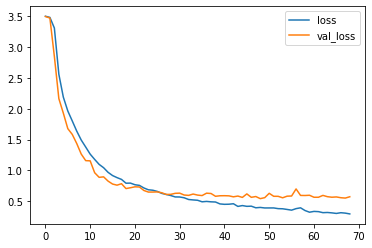

In [65]:
metrics[['loss' , 'val_loss']].plot()
plt.show()

In [24]:
# loading the model with the best validation accuracy
cnn_model.load_weights('weights.best.letters.hdf5')
cnn_model.evaluate(X_val, y_val)

2836/2836 [==============================] - 0s 128us/sample - loss: 0.5419 - accuracy: 0.8424 - top_3_categorical_accuracy: 0.9570


[0.5419041967526478, 0.8423836, 0.95698166]

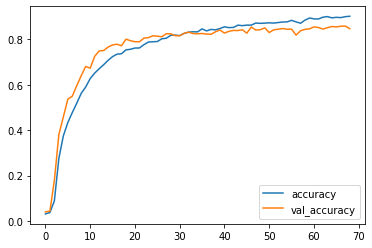

In [66]:
metrics[['accuracy' , 'val_accuracy']].plot()
plt.show()

In [72]:
y_pred=cnn_model.predict_classes(X_val)
y_pred

array([ 5, 26,  8, ..., 28,  8, 11])

## <font color='blue'>4.1 Load one prediction</font>

In [25]:
def load_image(path_filename):
	# load the image
	img = load_img(path_filename, target_size=(32, 32))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 32, 32, 3)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

In [26]:
def get_true_label(path_filename, dataframe, column_to_get):
    filename = os.path.basename(os.path.normpath(path_filename))
    index_row = data[data['file']==filename].index[0]
    return data.loc[index_row, column_to_get]

In [27]:
img = load_image(PATH_TO_DATA+'letters3/01_235.png')

predicted: а
true label: а


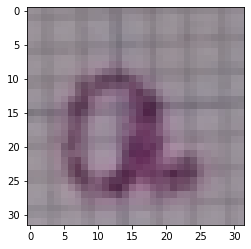

In [28]:
# predict the class
a_letter = cnn_model.predict_classes(img)

plt.imshow(img[0])
print('predicted:', letters[a_letter[0]])
print('true label:', get_true_label(PATH_TO_DATA+'letters3/01_235.png', data, 'letter'))

## <font color='blue'>4.2 Load multiple predictions</font>

In [29]:
def load_random_images(number_of_images_to_load = 9):
    images = []
    true_labels = []
    true_backgrounds = []
    
    which_folder = [random.randint(1,3) for _ in range(number_of_images_to_load)]
    for index_folder in which_folder:
        if index_folder == 1:
            path = PATH_TO_DATA+'letters/'
        else:
            path = PATH_TO_DATA+'letters'+str(index_folder)+'/'
        nb_files = len(os.listdir(path))
        
        index_image = random.randint(0, len(os.listdir(path)))
        
        image = load_image(path + os.listdir(path)[index_image])
        label = get_true_label(path + os.listdir(path)[index_image], data, 'letter')
        background = get_true_label(path + os.listdir(path)[index_image], data, 'background')

        images.append(image)
        true_labels.append(label)
        true_backgrounds.append(background)
        
    return images, true_labels, true_backgrounds

In [30]:
def classes_predictions(images_list_to_classify, true_labels, model):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):
        
        a_letter = model.predict_classes(image)
        associated_letter = letters[a_letter[0]]
        
        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Predicted Label: %s \n'%associated_letter+\
                  'True Label: %s\n'%true_labels[index],
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(image[0])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
        
    # show the figure
    plt.show()

In [31]:
test_images, true_labels, true_backgrounds = load_random_images()

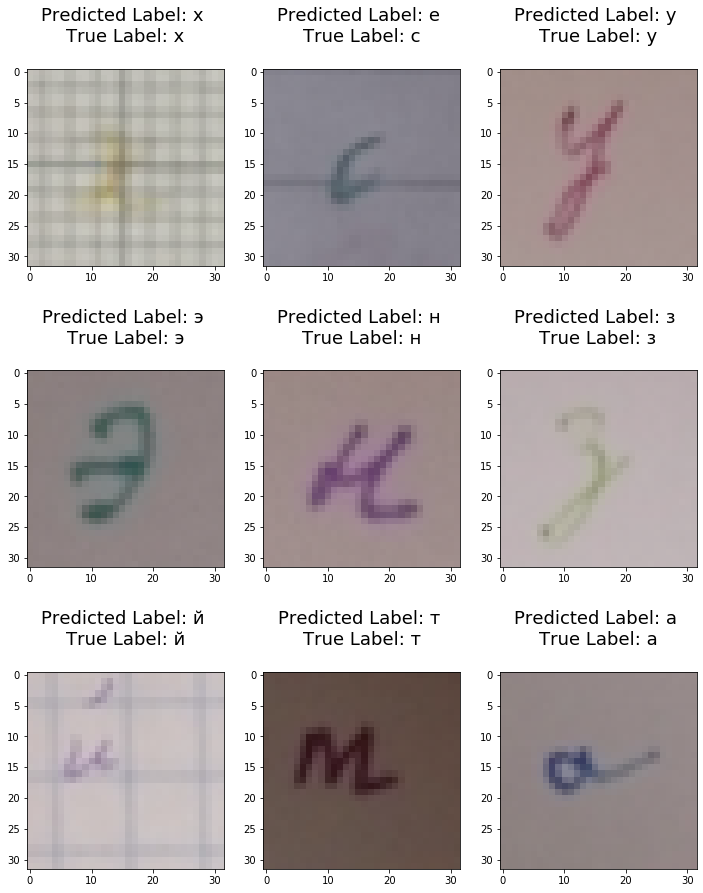

In [32]:
classes_predictions(test_images, true_labels, cnn_model)

# References

* Many thanks to <a href="https://www.kaggle.com/olgabelitskaya">Olga Belitskaya</a> for the huge work on the <a href="https://www.kaggle.com/olgabelitskaya/classification-of-handwritten-letters">data</a>
* Insightful <a href="https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d">article</a> on MNIST classification with CNN
* Explanation of <a href="https://computersciencewiki.org/index.php/Max-pooling_/_Pooling">MaxPooling</a>
* The <a href="https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484">vanishing gradient</a> problem